In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_businessinsider_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,10158631634154071,2021-04-05 19:59:13,📲🎉 Download the new Insider app! Enjoy faster ...,357,0.0,2.571382,0.326013,15.102605,2.24537,...,39,0.025641,2,3,39,-0.025641,0.152,0.052,0.795,0.6581
1,2,10158726095249071,2021-05-16 18:26:45,Cargo carriers flying the e-commerce industry'...,3,2.0,0.750000,0.375000,17.875000,0.37500,...,34,0.147059,1,0,34,0.029412,0.089,0.000,0.911,0.4215
2,3,10158726062944071,2021-05-16 18:14:39,"""Even toddlers know where guns are kept. So, t...",21,14.0,0.125000,0.000000,7.875000,0.12500,...,18,-0.166667,0,0,18,0.000000,0.000,0.000,1.000,0.0000
3,4,10158726018794071,2021-05-16 18:02:26,Opinion | While Americans are demanding action...,46,6.0,0.125000,1.500000,10.375000,-1.37500,...,14,0.000000,0,1,14,-0.071429,0.170,0.170,0.660,0.2500
4,5,10158725993204071,2021-05-16 17:50:13,The people who must come up with words when th...,11,2.0,1.250000,1.625000,12.125000,-0.37500,...,20,-0.100000,0,2,20,-0.100000,0.000,0.243,0.757,-0.9100


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

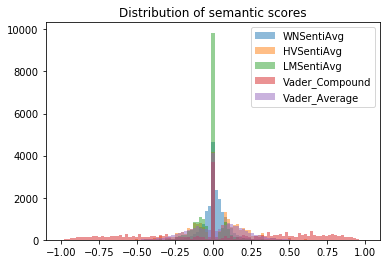

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

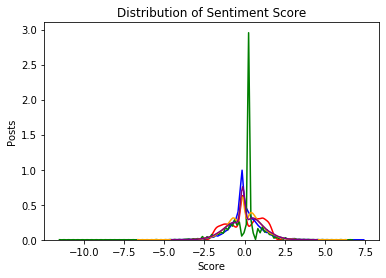

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,19270.000000,19270.000000,19270.000000,19270.000000,19270.000000
mean,0.014857,0.025428,-0.021789,0.058504,0.019992
std,0.076854,0.164442,0.086771,0.498363,0.164919
min,-0.625000,-1.000000,-1.000000,-0.982600,-0.662000
25%,-0.017857,-0.083333,-0.066667,-0.324825,-0.080000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.050000,0.125000,0.000000,0.476700,0.127000
max,0.562500,1.000000,0.538462,0.984100,0.697000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [8]:
post_data['DateMonth'].head()

0    2021-04
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -14.1356
p-value                           0.0000
#Lags Used                        6.0000
Number of Observations Used    1659.0000
Critical Value (1%)              -3.4343
Critical Value (5%)              -2.8633
Critical Value (10%)             -2.5677
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -10.7705
p-value                           0.0000
#Lags Used                        8.0000
Number of Observations Used    1657.0000
Critical Value (1%)              -3.4343
Critical Value (5%)              -2.8633
Critical Value (10%)             -2.5677
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -10.7705
p-value                           0.0000
#Lags Used                        8.0000
Number of Observations Used    1657.0000
Critical Value (1%)              -3.4343
Critical Value (5%)              -2.8633
Critical Value (10%)             -2.5677
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                  -18.0535
p-value                           0.0000
#Lags Used                        3.0000
Number of Observations Used    1662.0000
Critical Value (1%)              -3.4343
Critical Value (5%)              -2.8633
Critical Value (10%)             -2.5677
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2008-07-17,0.053571,1,0.000000,0.000000,0,0,6,0,0,6,0.053571,0.000000,0.0
2008-07-21,0.011905,1,0.000000,0.000000,3,1,28,0,0,28,0.011905,0.071429,0.0
2009-01-20,0.178571,3,-0.133967,-0.036333,1,1,30,0,0,30,0.059524,0.000000,0.0
2009-03-30,0.000000,1,0.000000,0.000000,0,0,3,0,0,3,0.000000,0.000000,0.0
2009-06-04,0.121875,2,0.000000,0.000000,0,0,13,0,0,13,0.060937,0.000000,0.0


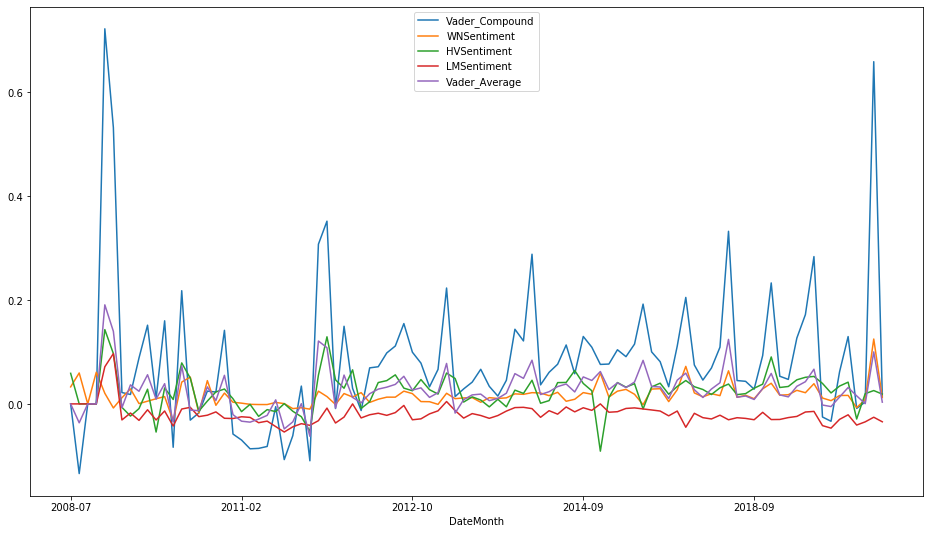

In [18]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [27]:
SnP_daily = web.get_data_yahoo('^GSPC','01/01/2015','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','01/01/2015','05/01/2021',interval='m')

In [28]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [29]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [30]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [31]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [32]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [33]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [34]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [35]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var][1:], Granger_data_daily['LogReturn'][1:])


Vader_Compound

Optimal number of lags for exog data is 2
Optimal number of lags for endog data is 2

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0760  , p=0.7830  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=0.0769  , p=0.7816  , df=1
likelihood ratio test: chi2=0.0769  , p=0.7816  , df=1
parameter F test:         F=0.0760  , p=0.7830  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0313  , p=0.9692  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=0.0638  , p=0.9686  , df=2
likelihood ratio test: chi2=0.0638  , p=0.9686  , df=2
parameter F test:         F=0.0313  , p=0.9692  , df_denom=254, df_num=2

Granger causality results of dep onto indep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0603  , p=0.1524  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=2.0844  , p=0.1488  , df=1
likelihood ratio test: chi2=2.

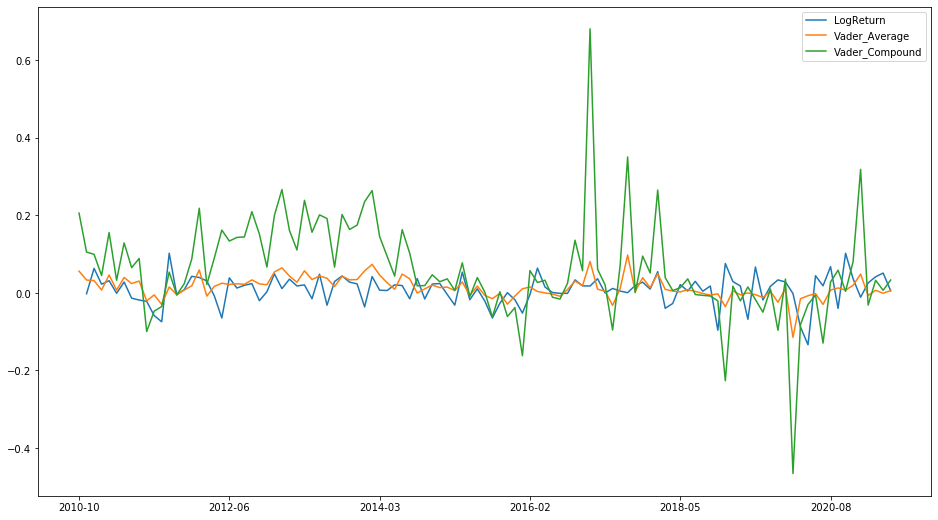

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [37]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment", 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.924337,0.552561,0.505689,0.583901,0.115977
Vader_Average,0.924337,1.000000,0.508356,0.561755,0.615088,0.066896
WNSentiment,0.552561,0.508356,1.000000,0.322145,0.378825,0.059034
HVSentiment,0.505689,0.561755,0.322145,1.000000,0.426291,0.059450
LMSentiment,0.583901,0.615088,0.378825,0.426291,1.000000,0.055428
LogReturn,0.115977,0.066896,0.059034,0.059450,0.055428,1.000000


In [36]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.054898
Vader_Average   0.230228
WNSentiment     0.341253
HVSentiment     0.283682
LMSentiment     0.319848


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
